In [1]:
from model import Network
from data import load_cifar100_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from metrics import lpips_gpu, psnr

# reproducibility
random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

In [2]:
# load to model
model_config = './model_config/fc1_cocktail_party_cifar100_instance.json'
checkpoint_path = './checkpoints/010224_fc1_cocktail_party_cifar100_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 4
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar100_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


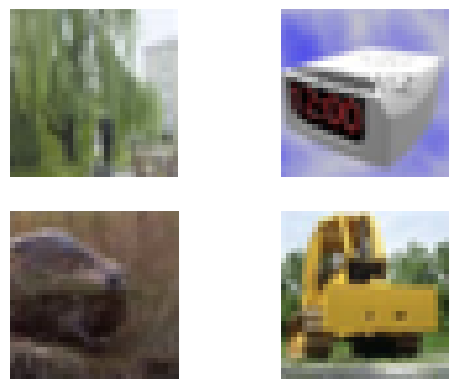

In [3]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [4]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([100, 3072])]


In [5]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [6]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 0.5268346884538906, 7.415861546208221, 4.910887792883931)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 9.12340259552002
loss: 5.319289684295654
loss: 5.018608570098877
loss: 4.980557918548584
loss: 4.9662604331970215
loss: 4.959848403930664
loss: 4.952165603637695
loss: 4.943779945373535
loss: 4.946646690368652
loss: 4.93794584274292
loss: 4.9416913986206055
loss: 4.938108444213867
loss: 4.94164514541626
loss: 4.943896293640137
loss: 4.937079906463623
loss: 4.940090179443359
loss: 4.937854290008545
loss: 4.937510013580322
loss: 4.934769630432129
loss: 4.938965797424316
loss: 4.930438995361328
loss: 4.935668468475342
loss: 4.934826374053955
loss: 4.936361312866211
loss: 4.933902740478516
loss: 4.9316582679748535


In [7]:
unmixing_matrix = unmixing_matrix.detach().to('cpu')
whitened_gradient = whitened_gradient.detach().to('cpu')

## PSNR Values

In [8]:
with torch.no_grad():
    psnr_match, psnr_is_positive, mean_psnr = psnr(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [9]:
psnr_match

[tensor([0, 0]), tensor([3, 1]), tensor([1, 3]), tensor([2, 2])]

In [10]:
mean_psnr

8.277947068214417

In [11]:
psnr_is_positive

[True, True, False, False]

## LPIPS

In [12]:
with torch.no_grad():
    lpips_match, lpips_is_positive, mean_lpips = lpips_gpu(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [13]:
lpips_match

[tensor([2, 3]), tensor([1, 0]), tensor([0, 1]), tensor([3, 2])]

In [14]:
mean_lpips

0.048199860379099846

In [15]:
lpips_is_positive

[True, True, False, False]

## Estimated images

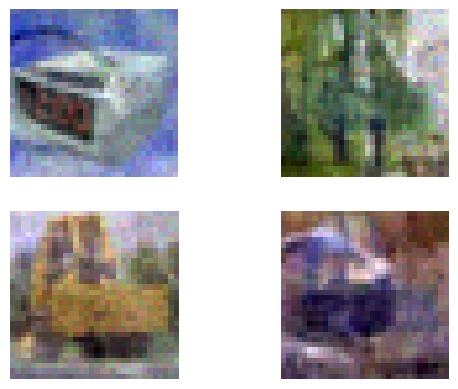

In [16]:
with torch.no_grad():
    estimated_img = (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(2, 2)
    
    for estimate_idx, (estimate, ax) in enumerate(zip(estimated_img, axes.flatten())):
        estimate_coeff = 1 if lpips_is_positive[lpips_match[estimate_idx][0].item()] else -1
        img = colors.Normalize()(np.asarray(estimate_coeff * estimate).reshape(3, 32, 32).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

## Original images

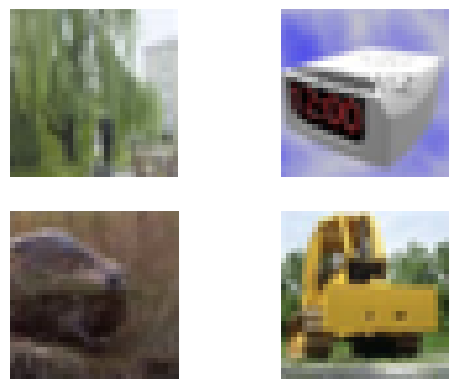

In [17]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()